## Example 14 - Pick up variable load

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

In [2]:
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0),
               "capacity": 10000}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(0.05, 0),
               "capacity": 10000}
data_node_3 = {"env": [],
               "name": "Node 3",
               "geometry": shapely.geometry.Point(0.10, 0),
               "capacity": 10000}
data_node_4 = {"env": [],
               "name": "Node 4",
               "geometry": shapely.geometry.Point(0.15, 0),
               "capacity": 10000}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

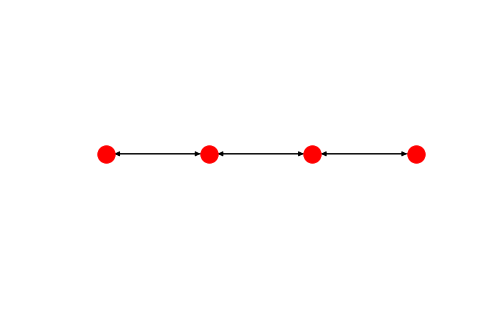

In [3]:
FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_1], # From node 2 to node 1
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3]] # From node 4 to node 3

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, duration = 1)

nx.draw(FG, positions)
plt.show()

### Create moving parts

In [4]:
def generate_passenger(origin, destination, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
    
    # Travel direction
    route = nx.dijkstra_path(environment.FG, origin, destination)
    
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route})

In [5]:
def generate_metro(origin, destination, environment):
    """ Generate a metro """
    Metro = type('Metro', 
                 (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, core.Routeable, core.Mover), 
                 {})

    # Name of the object
    name = "Metro"
    
    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
    
    # Travel direction
    route = nx.dijkstra_path(environment.FG, origin, destination)
    
    # Maximum passengers
    capacity = 10000
    
    return Metro(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry})

### Spawn the metro trains

In [6]:
def metro_1_4(env):
    while True:
        metro = generate_metro("Node 1", "Node 4", env)
        env.metros.append(metro)
        env.process(metro.move())
        
        # One metro every 20 minutes
        yield env.timeout(7 * 60)

In [7]:
def metro_4_1(env):
    while True:
        metro = generate_metro("Node 4", "Node 1", env)
        env.metros.append(metro)
        env.process(metro.move())
        
        # One metro every 20 minutes
        yield env.timeout(4 * 60)

In [8]:
def passengers(env):
    while True:
        origin, destination = random.sample(env.FG.nodes, 2)
        
        passenger = generate_passenger(origin, destination, env)
        FG.nodes[origin]["object_type"].units.append(passenger)
        
        passenger.log_entry("Waiting for metro start", env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
        env.passengers.append(passenger)
        
        # Random arrivals of passengers with mean interarrival time of 30 seconds
        yield env.timeout(random.random() * 60)

### Run simulation

In [9]:
# Simulation start time
simulation_start = datetime.datetime(2019, 1, 1)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.metros = []
env.passengers = []

# Start the simulation
env.process(metro_1_4(env))
env.process(metro_4_1(env))
env.process(passengers(env))
env.run(until = env.now + 24 * 60 * 60)

### Check results

In [10]:
env.passengers[5].route

['Node 4', 'Node 3', 'Node 2', 'Node 1']

In [11]:
# <__main__.Passenger at 0xa18416898>
# 'd75978a4-70a6-11e9-9b7f-7831c1d08f6a'
# env.passengers[8].__dict__

In [12]:
print("NODE 1:", FG.node['Node 1']['geometry'])
print("NODE 2:", FG.node['Node 2']['geometry'])
print("NODE 3:", FG.node['Node 3']['geometry'])
print("NODE 4:", FG.node['Node 4']['geometry'])

NODE 1: POINT (0 0)
NODE 2: POINT (0.05 0)
NODE 3: POINT (0.1 0)
NODE 4: POINT (0.15 0)


In [13]:
pd.DataFrame.from_dict(env.passengers[3].log)

,Message,Timestamp,Value,Geometry
0,Waiting for metro start,2019-01-01 00:02:16.691950,0,POINT (0.05 0)
1,Waiting for metro stop,2019-01-01 01:32:45.974540,0,POINT (0.05 0)
2,In metro start,2019-01-01 01:32:45.974540,0,POINT (0.05 0)
3,In metro stop,2019-01-01 04:38:17.923619,0,POINT (0.15 0)


In [14]:
env.passengers[3].route

['Node 2', 'Node 3', 'Node 4']

In [15]:
env.passengers[3].id

'c098bf8c-70cf-11e9-b895-7831c1d08f6a'

In [16]:
pd.DataFrame.from_dict(env.metros[3].log)

,Message,Timestamp,Value,Geometry
0,Loading start,2019-01-01 00:07:00.000000,0,POINT (0 0)
1,Loading stop,2019-01-01 00:07:00.000000,30,POINT (0 0)
2,Sailing from node Node 1 to node Node 2 start,2019-01-01 00:07:00.000000,0,POINT (0 0)
3,Sailing from node Node 1 to node Node 2 stop,2019-01-01 01:39:45.974540,0,POINT (0.05 0)
4,Unloading start,2019-01-01 01:39:45.974540,0,POINT (0.05 0)
5,Unloading stop,2019-01-01 01:39:45.974540,30,POINT (0.05 0)
6,Loading start,2019-01-01 01:39:45.974540,0,POINT (0.05 0)
7,Loading stop,2019-01-01 01:39:45.974540,30,POINT (0.05 0)
8,Sailing from node Node 2 to node Node 3 start,2019-01-01 01:39:45.974540,0,POINT (0.05 0)
9,Sailing from node Node 2 to node Node 3 stop,2019-01-01 03:12:31.949080,0,POINT (0.1 0)


In [17]:
env.metros[3].log

{'Message': ['Loading start',
  'Loading stop',
  'Sailing from node Node 1 to node Node 2 start',
  'Sailing from node Node 1 to node Node 2 stop',
  'Unloading start',
  'Unloading stop',
  'Loading start',
  'Loading stop',
  'Sailing from node Node 2 to node Node 3 start',
  'Sailing from node Node 2 to node Node 3 stop',
  'Unloading start',
  'Unloading stop',
  'Loading start',
  'Loading stop',
  'Sailing from node Node 3 to node Node 4 start',
  'Sailing from node Node 3 to node Node 4 stop',
  'Unloading start',
  'Unloading stop'],
 'Timestamp': [datetime.datetime(2019, 1, 1, 0, 7),
  datetime.datetime(2019, 1, 1, 0, 7),
  datetime.datetime(2019, 1, 1, 0, 7),
  datetime.datetime(2019, 1, 1, 1, 39, 45, 974540),
  datetime.datetime(2019, 1, 1, 1, 39, 45, 974540),
  datetime.datetime(2019, 1, 1, 1, 39, 45, 974540),
  datetime.datetime(2019, 1, 1, 1, 39, 45, 974540),
  datetime.datetime(2019, 1, 1, 1, 39, 45, 974540),
  datetime.datetime(2019, 1, 1, 1, 39, 45, 974540),
  datetim

In [19]:
logs = []
for i in range(len(env.passengers)):
    logs.append(env.passengers[i].log['Message'])

In [24]:
logs.count(['Waiting for metro start',
  'Waiting for metro stop',
  'In metro start',
  'In metro stop'])

2563

In [25]:
logs.count(['Waiting for metro start'])

19

In [27]:
logs.count(['Waiting for metro start',
  'Waiting for metro stop',
  'In metro start'])

326

In [28]:
logs.count(['Waiting for metro start',
  'Waiting for metro stop'])

0